In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import json
import numpy as np
from numpy import linalg as LA
import torch 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
from torch.utils.data import Subset
# documentation
# https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html
def frobenius_distance(matrix1, matrix2):
    return LA.norm(matrix1-matrix2, None)

Load the first image pose

In [2]:
with open('pose_query_image.json', 'r') as file:
    first_image_rep = json.load(file)["image_0"]
first_image_rep = np.array(first_image_rep)

Load all other image representations from the validation set

In [3]:
with open('pose_rest_images.json', 'r') as file:
    all_images_rep = json.load(file)

Sanity check


In [4]:
print("The number of keys in the dictionary:", len(all_images_rep)) # 4859

The number of keys in the dictionary: 4859


Measure the Frobenius norm between the first image and all other images


In [5]:
frobenius_norms = {}
for image_id, representation in all_images_rep.items():
    representation = np.array(representation)  
    frobenius_norms[image_id] = frobenius_distance(first_image_rep, representation)

Obtain the first three closest neighbors

In [6]:
closest_images = sorted(frobenius_norms.items(), key=lambda x: x[1])
closest_image_ids = []
for image_id, distance in closest_images[:3]:
    print(f"{image_id}: {distance}")
    closest_image_ids.append(image_id)

image_1989: 7.395445222442245
image_3216: 7.940410681469648
image_1910: 9.955621117229448


Now lets see their metadata, like the elevation, lightning, and azimuth values

In [7]:
# Loader taken from https://github.com/mavanb/vision/blob/448fac0f38cab35a387666d553b9d5e4eec4c5e6/torchvision/datasets/utils.py

from __future__ import print_function
import os
import errno
import struct

import torch
import torch.utils.data as data
import numpy as np
from PIL import Image
from torchvision.datasets.utils import download_url, check_integrity


class smallNORB_with_info(data.Dataset):
    """`MNIST <https://cs.nyu.edu/~ylclab/data/norb-v1.0-small//>`_ Dataset.
    Args:
        root (string): Root directory of dataset where processed folder and
            and  raw folder exist.
        train (bool, optional): If True, creates dataset from the training files,
            otherwise from the test files.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If the dataset is already processed, it is not processed
            and downloaded again. If dataset is only already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        info_transform (callable, optional): A function/transform that takes in the
            info and transforms it.
        mode (string, optional): Denotes how the images in the data files are returned. Possible values:
            - all (default): both left and right are included separately.
            - stereo: left and right images are included as corresponding pairs.
            - left: only the left images are included.
            - right: only the right images are included.
    """

    dataset_root = "https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/"
    data_files = {
        'train': {
            'dat': {
                "name": 'smallnorb-5x46789x9x18x6x2x96x96-training-dat.mat',
                "md5_gz": "66054832f9accfe74a0f4c36a75bc0a2",
                "md5": "8138a0902307b32dfa0025a36dfa45ec"
            },
            'info': {
                "name": 'smallnorb-5x46789x9x18x6x2x96x96-training-info.mat',
                "md5_gz": "51dee1210a742582ff607dfd94e332e3",
                "md5": "19faee774120001fc7e17980d6960451"
            },
            'cat': {
                "name": 'smallnorb-5x46789x9x18x6x2x96x96-training-cat.mat',
                "md5_gz": "23c8b86101fbf0904a000b43d3ed2fd9",
                "md5": "fd5120d3f770ad57ebe620eb61a0b633"
            },
        },
        'test': {
            'dat': {
                "name": 'smallnorb-5x01235x9x18x6x2x96x96-testing-dat.mat',
                "md5_gz": "e4ad715691ed5a3a5f138751a4ceb071",
                "md5": "e9920b7f7b2869a8f1a12e945b2c166c"
            },
            'info': {
                "name": 'smallnorb-5x01235x9x18x6x2x96x96-testing-info.mat',
                "md5_gz": "a9454f3864d7fd4bb3ea7fc3eb84924e",
                "md5": "7c5b871cc69dcadec1bf6a18141f5edc"
            },
            'cat': {
                "name": 'smallnorb-5x01235x9x18x6x2x96x96-testing-cat.mat',
                "md5_gz": "5aa791cd7e6016cf957ce9bdb93b8603",
                "md5": "fd5120d3f770ad57ebe620eb61a0b633"
            },
        },
    }

    raw_folder = 'raw'
    processed_folder = 'processed'
    train_image_file = 'train_img'
    train_label_file = 'train_label'
    train_info_file = 'train_info'
    test_image_file = 'test_img'
    test_label_file = 'test_label'
    test_info_file = 'test_info'
    extension = '.pt'

    def __init__(self, root, train=True, transform=None, target_transform=None, info_transform=None, download=False,
                 mode="all"):

        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.info_transform = info_transform
        self.train = train  # training set or test set
        self.mode = mode

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

        # load test or train set
        image_file = self.train_image_file if self.train else self.test_image_file
        label_file = self.train_label_file if self.train else self.test_label_file
        info_file = self.train_info_file if self.train else self.test_info_file

        # load labels
        self.labels = self._load(label_file)

        # load info files
        self.infos = self._load(info_file)

        # load right set
        if self.mode == "left":
            self.data = self._load("{}_left".format(image_file))

        # load left set
        elif self.mode == "right":
            self.data = self._load("{}_right".format(image_file))

        # we load them all 
        elif self.mode == "all" or self.mode == "stereo":
            left_data = self._load("{}_left".format(image_file))
            right_data = self._load("{}_right".format(image_file))

            # load stereo
            if self.mode == "stereo":
                self.data = torch.stack((left_data, right_data), dim=1)

            # load all
            else:
                self.data = torch.cat((left_data, right_data), dim=0)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            mode ``all'', ``left'', ``right'':
                tuple: (image, target, info)
            mode ``stereo'':
                tuple: (image left, image right, target, info)
        """
        target = self.labels[index % 24300] if self.mode is "all" else self.labels[index]
        if self.target_transform is not None:
            target = self.target_transform(target)

        info = self.infos[index % 24300] if self.mode is "all" else self.infos[index]
        if self.info_transform is not None:
            info = self.info_transform(info)

        if self.mode == "stereo":
            img_left = self._transform(self.data[index, 0])
            img_right = self._transform(self.data[index, 1])
            return img_left, img_right, target, info

        img = self._transform(self.data[index])
        return img, target, info

    def __len__(self):
        return len(self.data)

    def _transform(self, img):
        # doing this so that it is consistent with all other data sets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)
        return img

    def _load(self, file_name):
        return torch.load(os.path.join(self.root, self.processed_folder, file_name + self.extension))

    def _save(self, file, file_name):
        with open(os.path.join(self.root, self.processed_folder, file_name + self.extension), 'wb') as f:
            torch.save(file, f)

    def _check_exists(self):
        """ Check if processed files exists."""
        files = (
            "{}_left".format(self.train_image_file),
            "{}_right".format(self.train_image_file),
            "{}_left".format(self.test_image_file),
            "{}_right".format(self.test_image_file),
            self.test_label_file,
            self.train_label_file
        )
        fpaths = [os.path.exists(os.path.join(self.root, self.processed_folder, f + self.extension)) for f in files]
        return False not in fpaths

    def _flat_data_files(self):
        return [j for i in self.data_files.values() for j in list(i.values())]

    def _check_integrity(self):
        """Check if unpacked files have correct md5 sum."""
        root = self.root
        for file_dict in self._flat_data_files():
            filename = file_dict["name"]
            md5 = file_dict["md5"]
            fpath = os.path.join(root, self.raw_folder, filename)
            if not check_integrity(fpath, md5):
                return False
        return True

    def download(self):
        """Download the SmallNORB data if it doesn't exist in processed_folder already."""
        import gzip

        if self._check_exists():
            return

        # check if already extracted and verified
        if self._check_integrity():
            print('Files already downloaded and verified')
        else:
            # download and extract
            for file_dict in self._flat_data_files():
                url = self.dataset_root + file_dict["name"] + '.gz'
                filename = file_dict["name"]
                gz_filename = filename + '.gz'
                md5 = file_dict["md5_gz"]
                fpath = os.path.join(self.root, self.raw_folder, filename)
                gz_fpath = fpath + '.gz'

                # download if compressed file not exists and verified
                download_url(url, os.path.join(self.root, self.raw_folder), gz_filename, md5)

                print('# Extracting data {}\n'.format(filename))

                with open(fpath, 'wb') as out_f, \
                        gzip.GzipFile(gz_fpath) as zip_f:
                    out_f.write(zip_f.read())

                os.unlink(gz_fpath)

        # process and save as torch files
        print('Processing...')

        # create processed folder
        try:
            os.makedirs(os.path.join(self.root, self.processed_folder))
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

        # read train files
        left_train_img, right_train_img = self._read_image_file(self.data_files["train"]["dat"]["name"])
        train_info = self._read_info_file(self.data_files["train"]["info"]["name"])
        train_label = self._read_label_file(self.data_files["train"]["cat"]["name"])

        # read test files
        left_test_img, right_test_img = self._read_image_file(self.data_files["test"]["dat"]["name"])
        test_info = self._read_info_file(self.data_files["test"]["info"]["name"])
        test_label = self._read_label_file(self.data_files["test"]["cat"]["name"])

        # save training files
        self._save(left_train_img, "{}_left".format(self.train_image_file))
        self._save(right_train_img, "{}_right".format(self.train_image_file))
        self._save(train_label, self.train_label_file)
        self._save(train_info, self.train_info_file)

        # save test files
        self._save(left_test_img, "{}_left".format(self.test_image_file))
        self._save(right_test_img, "{}_right".format(self.test_image_file))
        self._save(test_label, self.test_label_file)
        self._save(test_info, self.test_info_file)

        print('Done!')

    @staticmethod
    def _parse_header(file_pointer):
        # Read magic number and ignore
        struct.unpack('<BBBB', file_pointer.read(4))  # '<' is little endian)

        # Read dimensions
        dimensions = []
        num_dims, = struct.unpack('<i', file_pointer.read(4))  # '<' is little endian)
        for _ in range(num_dims):
            dimensions.extend(struct.unpack('<i', file_pointer.read(4)))

        return dimensions

    def _read_image_file(self, file_name):
        fpath = os.path.join(self.root, self.raw_folder, file_name)
        with open(fpath, mode='rb') as f:
            dimensions = self._parse_header(f)
            assert dimensions == [24300, 2, 96, 96]
            num_samples, _, height, width = dimensions

            left_samples = np.zeros(shape=(num_samples, height, width), dtype=np.uint8)
            right_samples = np.zeros(shape=(num_samples, height, width), dtype=np.uint8)

            for i in range(num_samples):

                # left and right images stored in pairs, left first
                left_samples[i, :, :] = self._read_image(f, height, width)
                right_samples[i, :, :] = self._read_image(f, height, width)

        return torch.ByteTensor(left_samples), torch.ByteTensor(right_samples)

    @staticmethod
    def _read_image(file_pointer, height, width):
        """Read raw image data and restore shape as appropriate. """
        image = struct.unpack('<' + height * width * 'B', file_pointer.read(height * width))
        image = np.uint8(np.reshape(image, newshape=(height, width)))
        return image

    def _read_label_file(self, file_name):
        fpath = os.path.join(self.root, self.raw_folder, file_name)
        with open(fpath, mode='rb') as f:
            dimensions = self._parse_header(f)
            assert dimensions == [24300]
            num_samples = dimensions[0]

            struct.unpack('<BBBB', f.read(4))  # ignore this integer
            struct.unpack('<BBBB', f.read(4))  # ignore this integer

            labels = np.zeros(shape=num_samples, dtype=np.int32)
            for i in range(num_samples):
                category, = struct.unpack('<i', f.read(4))
                labels[i] = category
            return torch.LongTensor(labels)

    def _read_info_file(self, file_name):
        fpath = os.path.join(self.root, self.raw_folder, file_name)
        with open(fpath, mode='rb') as f:

            dimensions = self._parse_header(f)
            assert dimensions == [24300, 4]
            num_samples, num_info = dimensions

            struct.unpack('<BBBB', f.read(4))  # ignore this integer

            infos = np.zeros(shape=(num_samples, num_info), dtype=np.int32)

            for r in range(num_samples):
                for c in range(num_info):
                    info, = struct.unpack('<i', f.read(4))
                    infos[r, c] = info

        return torch.LongTensor(infos)

<>:146: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:150: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:146: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:150: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\athac\AppData\Local\Temp\ipykernel_48096\3670663390.py:146: SyntaxWarning: "is" with a literal. Did you mean "=="?
  target = self.labels[index % 24300] if self.mode is "all" else self.labels[index]
C:\Users\athac\AppData\Local\Temp\ipykernel_48096\3670663390.py:150: SyntaxWarning: "is" with a literal. Did you mean "=="?
  info = self.infos[index % 24300] if self.mode is "all" else self.infos[index]


In [8]:
def exclude_bias_and_norm(p):
    return p.ndim == 1

def get_train_valid_loader(data_dir,
                           dataset,
                           batch_size,
                           random_seed,
                           exp='azimuth',
                           valid_size=0.1,
                           shuffle=True,
                           num_workers=4,
                           pin_memory=False):

    data_dir = data_dir + '/' + dataset

    trans = [  
                transforms.ToTensor(),
            ]
        
    dataset = smallNORB_with_info(data_dir, train=True, download=True,
                    transform = transforms.Compose(trans))

    num_train = len(dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
 
    valid_idx = indices[:split]
    valid_set = Subset(dataset, valid_idx)

    valid_loader = torch.utils.data.DataLoader(
        valid_set, batch_size=1, shuffle=False,
        num_workers=num_workers, pin_memory=pin_memory,
    ) 
    
    return valid_loader

Visualise the query image and the nearest neighbors

Using device: cuda
GPU is available
Data loaders created successfully
i = 0
labels tensor([0])
info tensor([[ 9,  5, 14,  3]])


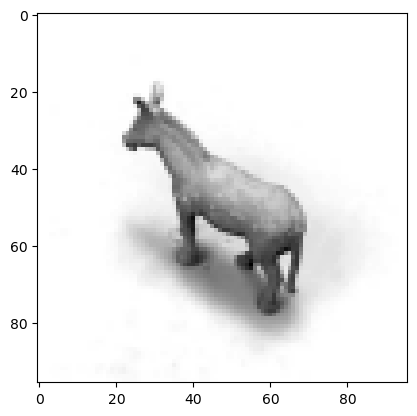

i = 1910
labels tensor([0])
info tensor([[ 9,  3, 14,  1]])


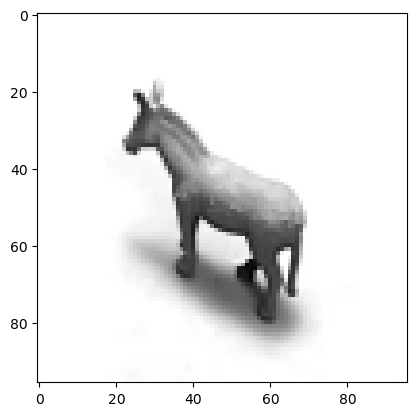

i = 1989
labels tensor([0])
info tensor([[ 7,  0, 20,  1]])


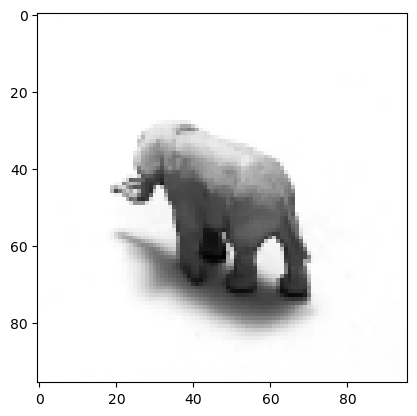

i = 3216
labels tensor([0])
info tensor([[ 9,  8, 14,  0]])


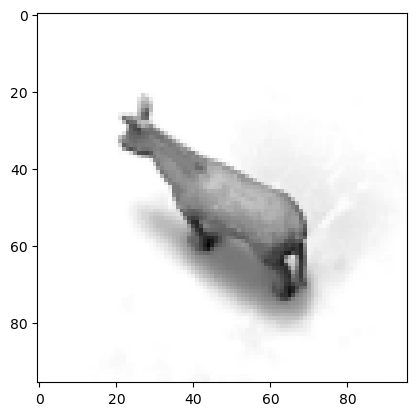

In [9]:
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.manual_seed(2019)
kwargs = {}
if torch.cuda.is_available():
    # configure the random seed as they do
    torch.cuda.manual_seed(2018)
    kwargs = {'num_workers': 0, 'pin_memory': False}
    torch.cuda.set_device("cuda:0")
    print("GPU is available")
        
# also config these
valid_loader = get_train_valid_loader(
    "./data", "smallNorb", 1,
    2018, "full", 0.1,
    "True", **kwargs
) 
print("Data loaders created successfully")
    
for i, data in enumerate(valid_loader, 0):
    # Visualizing the images
    if i==0:
        # Visualizing the first one-the query image
        images, labels, info  = data
        npimg = images.numpy()
        print('i =', i)
        print("labels", labels)
        print("info", info)
        plt.imshow(npimg.squeeze(), cmap='gray') 
        plt.show()
        
    if "image_"+str(i) in closest_image_ids:
        images, labels, info  = data
            
        npimg = images.numpy()
        print('i =', i)
        print("labels", labels)
        print("info", info)
        plt.imshow(npimg.squeeze(), cmap='gray') 
        plt.show()